Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import gc
import sys
import time
import functools
import tarfile
from pprint import pprint
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
""" 
Important variables used in the data downloand and extraction process.
As we do not need to run the process again, variables are placed here.
"""
data_root = '.'
num_classes = 10
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
small_path = 'notMNIST_small/'
large_path = 'notMNIST_large'

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
#data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [4]:
#num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [3]:
A_s = os.listdir(small_path + 'A/')
J_s = os.listdir(small_path + 'J/')

display(Image(small_path + 'A/' + A_s[10]))
display(Image(small_path + 'A/' + A_s[15]))
display(Image(small_path + 'J/' + J_s[15]))
display(Image(small_path + 'J/' + J_s[1000]))

In [4]:
gc.collect()

0

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [4]:
#image_size = 28  # Pixel width and height.
#pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth  #Normalize the input
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

#train_datasets = maybe_pickle(train_folders, 45000)
#test_datasets = maybe_pickle(test_folders, 1800)

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

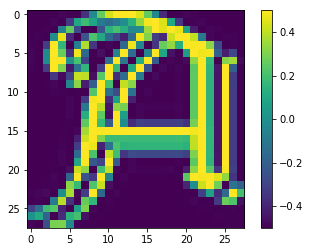

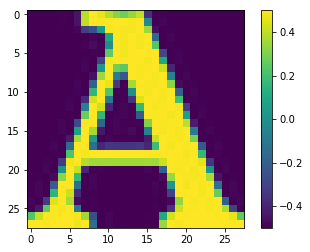

16.4097


In [5]:
A_s = pickle.load(open('./notMNIST_small/A.pickle'))
def display_letter(image_matrix):
    plt.imshow(image_matrix)
    plt.colorbar()
    plt.show()

def display_letter_2(image_matrix):
    plt.imshow(toimage(image_matrix))
    ptl.show()
    
display_letter(A_s[0])
display_letter(A_s[1334])

diff = A_s[440] - A_s[1334]
print (np.linalg.norm(diff))

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [6]:
classes = os.listdir('./notMNIST_large')
class_sizes = {}
for cls in classes:
    letter = pickle.load(open('./notMNIST_large/' + cls))
    class_sizes[cls] = letter.shape
del(letter)
from pprint import pprint
pprint (class_sizes)

{'A.pickle': (52909, 28, 28),
 'B.pickle': (52911, 28, 28),
 'C.pickle': (52912, 28, 28),
 'D.pickle': (52911, 28, 28),
 'E.pickle': (52912, 28, 28),
 'F.pickle': (52912, 28, 28),
 'G.pickle': (52912, 28, 28),
 'H.pickle': (52912, 28, 28),
 'I.pickle': (52912, 28, 28),
 'J.pickle': (52911, 28, 28)}


<h4> data is not balanced accross classes </h4>

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [11]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files) #10 letters
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes #=5000
  tsize_per_class = train_size // num_classes #=40000
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 400000
valid_size = 50000
test_size = 10000
train_folder = 'notMNIST_large/'
test_folder = 'notMNIST_small/'
train_datasets = os.listdir(train_folder)
train_datasets = [train_folder + f for f in train_datasets if '.pickle' in f]
test_datasets = os.listdir(test_folder)
test_datasets = [test_folder + f for f in test_datasets if '.pickle' in f]

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (400000, 28, 28) (400000,)
Validation: (50000, 28, 28) (50000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [12]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

<h4> The same permutation was used for shuffling the dataset and the labels. Therefore each datapoint matches it's label. On a side note, I am unsure if the training and test distributions match. </h4>

Finally, let's save the data for later reuse:

In [13]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [14]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1444400441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [4]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
datasets = pickle.load(open(pickle_file))

locals().update(datasets) #vars = train_labels,valid_labels,test_labels,test_dataset,train_dataset,valid_dataset 
del(datasets)
label_mapping = { 0:'B',
                  7:'C',
                  9:'I',
                  4:'A',
                  6:'H',
                  3:'J',
                  8:'F',
                  1:'E',
                  2:'D',
                  5:'G',
                 }

In [5]:
#Time a function
def timeit(func):
    @functools.wraps(func)
    def newfunc(*args, **kwargs):
        startTime = time.time()
        results = func(*args, **kwargs)
        elapsedTime = time.time() - startTime
        print('function [{}] finished in {} ms'.format(
            func.__name__, int(elapsedTime * 1000)))
        return results
    return newfunc

In [6]:
def order_datasets(dset_one,dset_two):
    #Order 2 datasets in descending order
    if dset_one.shape[0] >= dset_two.shape[1]:
        return dset_one,dset_two
    else:
        return dset_two,dset_one
    
def close_to_zero(array,lower,upper):
    norm = np.linalg.norm(array)
    if upper == lower == 0:
        if norm == 0:
            return True
        else:
            return False
        
    if norm < upper and norm >= lower:
        return True
    else:
        return False
    
def concat_overlaps(overlap):   #Method incomlete
    #Remove images that are not overlapping from dictionary
    #If there are more than 2 images that are equal, they are counted more than once.
    #Remove those images
    overlap_ = {}
    overlap_values = []
    for o in overlap:
        if overlap[o]:
            overlap_values.extend(overlap[0])
            overlap_[o] = overlap[o]
    
    _overlap_ = {}
    for o in overlap_:
        if o not in overlap_values:
            _overlap_[o] = overlap_[o]
        
    return _overlap_
        
def make_dict(num):
    d = {}
    for i in range(0,num):
        d[i] = []
    return d

@timeit
def calculate_overlap_ratio_1(dset_one,dset_two,duplicate_cuttoff,near_overlap=False,same_dataset=False):
    """
    Calculate Ratios.
    Attempt One. Runs in O(n^2)
    For larger datasets, this is too slow.
    Read at the end for a faster algorithm proposal.
    """
    #If near_duplicates == True, return exact duplicates and near dupliates.
    dset_one,dset_two = order_datasets(dset_one,dset_two)
    zeros = np.zeros((image_size,image_size))
    overlap = make_dict(dset_one.shape[0])
    if near_overlap:
        overlap_near = make_dict(dset_one.shape[0])
    dset_two_len = len(dset_two)
    dset_one_len = len(dset_one)
    total = dset_two_len + dset_one_len
    
    if same_dataset:
        q = 1
    else:
        q = 0
    for i in range(0,dset_one_len):
        if i <= dset_two_len:
            for j in range(i+q,dset_two_len):
                if dset_one[i].shape != dset_two[j].shape != zeros.shape:
                    raise Exception('Something went wrong. Was expecting arrays of the same size')

                #If the norm of the differnce is approximately 0, then the images are near duplicates
                #
                diff = dset_one[i] - dset_two[j]
                if close_to_zero(diff,0,0):
                    overlap[i].append(j)

                if near_overlap:
                    if close_to_zero(diff,0,duplicate_cuttoff):
                        overlap_near[i].append(j)

    
    if near_overlap:
        overlap,overlap_near = concat_overlaps(overlap),concat_overlaps(overlap_near)
        return overlap,overlap_near,{'overlap_ratio':len(overlap)/float(total),
                                      'overlap_near_ratio': len(overlap_near)/float(total)}
    else:
        overlap = concat_overlaps(overlap)
        return overlap,{'overlap_ratio':len(overlap)/float(total)}

<h4> Testing Equality and Near duplicates Definition </h4>
<p> 
    One thing to note, exact duplicates, mathematically, implies strict equality,
    but there are some image matrices whose distances from one another is almost zero and
    visually, the images look similar. Since we are pruning duplicates and near duplicates,
    the definition does not matter and we shall proceed to define equality mathematically.
     However, we need to define a maximum distance value that will define the cutoff point for when two images are near duplicates.
</p>

Cutt Off Value 0 - 0.999
Distance 0.0


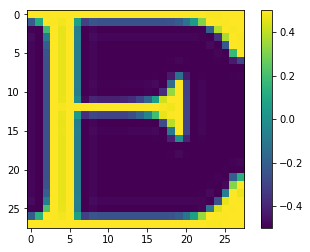

Valid Image # 47410


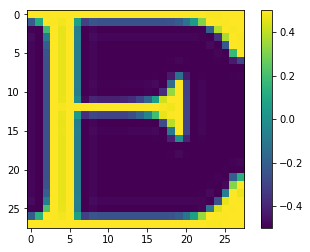

Test Image # 3552
********************************************************************************
********************************************************************************

Cutt Off Value 1 - 1.999
Distance 1.7542


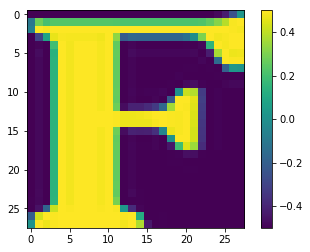

Valid Image # 31293


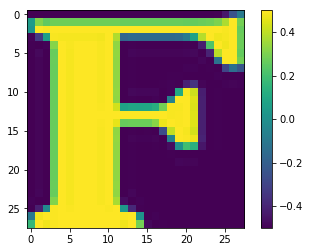

Test Image # 2874
********************************************************************************
********************************************************************************

Cutt Off Value 2 - 2.999
Distance 2.94125


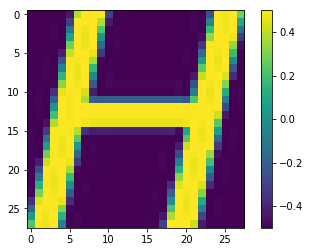

Valid Image # 41783


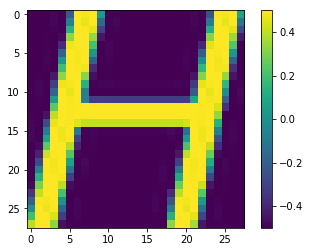

Test Image # 8311
********************************************************************************
********************************************************************************

Cutt Off Value 3 - 3.999
Distance 3.91774


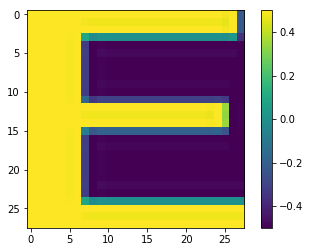

Valid Image # 47470


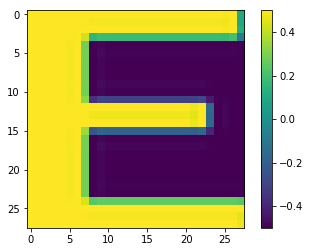

Test Image # 2128
********************************************************************************
********************************************************************************

Cutt Off Value 4 - 4.999
Distance 4.78731


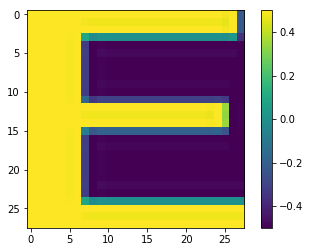

Valid Image # 47470


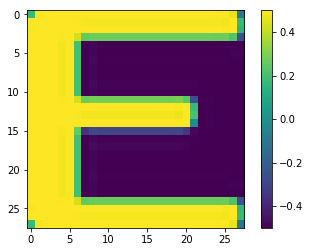

Test Image # 10
********************************************************************************
********************************************************************************

Cutt Off Value 5 - 5.999
Distance 5.41757


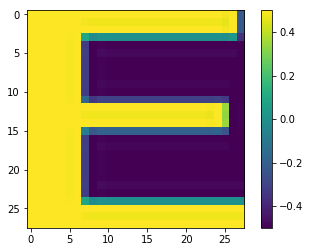

Valid Image # 47470


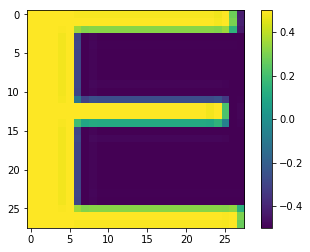

Test Image # 2245
********************************************************************************
********************************************************************************

Cutt Off Value 6 - 6.999
Distance 6.69394


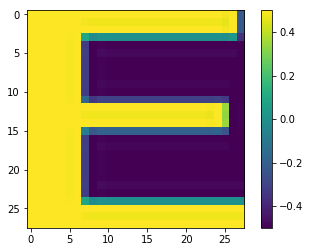

Valid Image # 47470


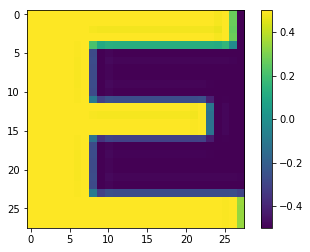

Test Image # 8524
********************************************************************************
********************************************************************************

Cutt Off Value 7 - 7.999
Distance 7.20051


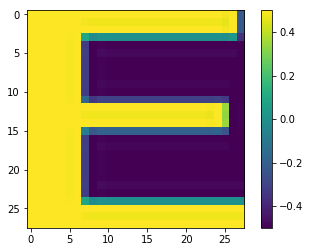

Valid Image # 47470


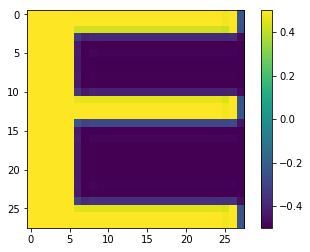

Test Image # 3050
********************************************************************************
********************************************************************************

Cutt Off Value 8 - 8.999
Distance 8.98141


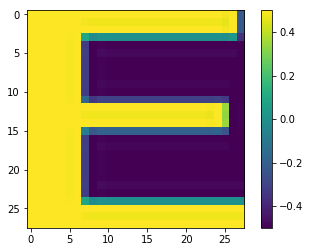

Valid Image # 47470


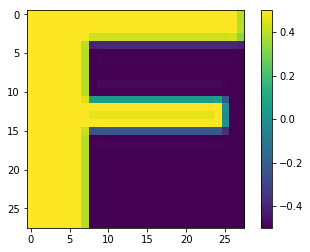

Test Image # 9378
********************************************************************************
********************************************************************************

Cutt Off Value 9 - 9.999
Distance 9.9892


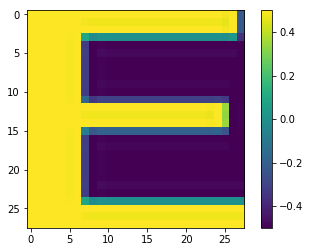

Valid Image # 47470


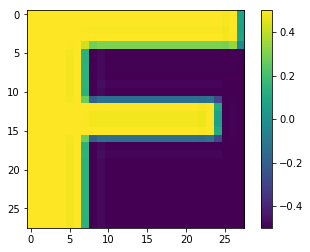

Test Image # 805
********************************************************************************
********************************************************************************

Cutt Off Value 10 - 10.999
Distance 10.8105


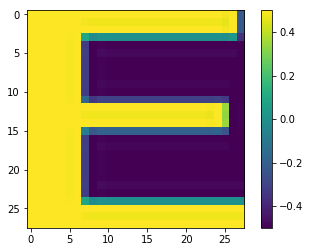

Valid Image # 47470


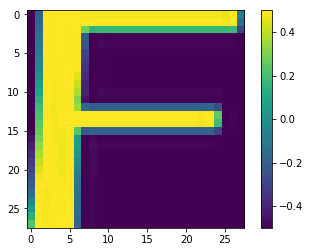

Test Image # 6676
********************************************************************************
********************************************************************************

Cutt Off Value 11 - 11.999
Distance 11.807


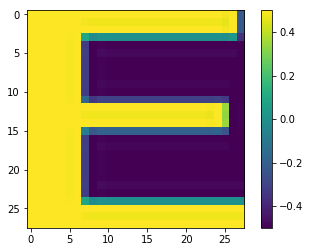

Valid Image # 47470


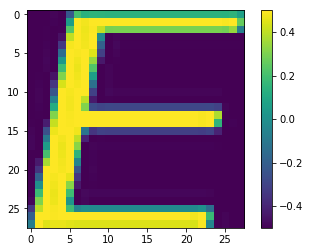

Test Image # 8041
********************************************************************************
********************************************************************************

Cutt Off Value 12 - 12.999
Distance 12.9251


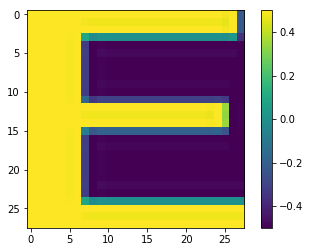

Valid Image # 47470


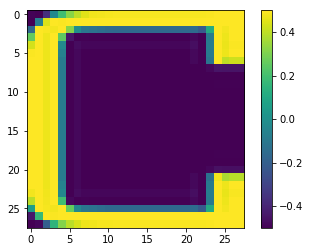

Test Image # 5260
********************************************************************************
********************************************************************************

Cutt Off Value 13 - 13.999
Distance 13.2378


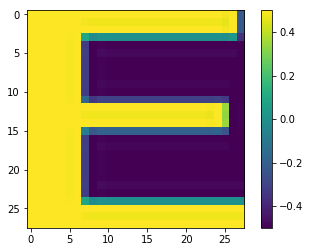

Valid Image # 47470


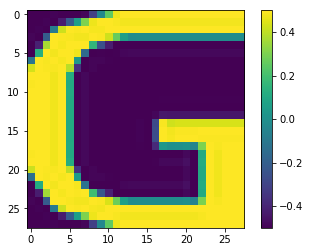

Test Image # 14
********************************************************************************
********************************************************************************

Cutt Off Value 14 - 14.999
Distance 14.9764


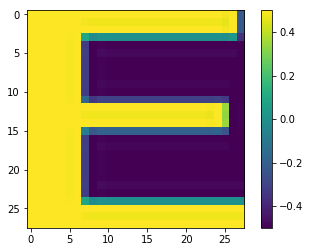

Valid Image # 47470


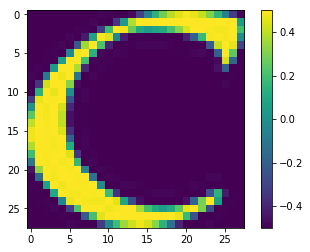

Test Image # 8855
********************************************************************************
********************************************************************************



In [18]:
from random import shuffle
def view_equality_cuttoff(randomize=True):
    cutt_off_images = {x: [] for x in range(0,15)}
    cutt_offs = {x: None for x in range(0,15)}
    
    v_range = range(0,len(valid_dataset))
    t_range = range(0,len(test_dataset))
    if randomize:
        shuffle(v_range)
        shuffle(t_range)
    
    for i in v_range:
        for j in t_range:
            if not cutt_offs:
                for k in range(0,15):
                    print ('Cutt Off Value',k,'-',k + .999)
                    print ('Distance',np.linalg.norm(valid_dataset[cutt_off_images[k][0]]-test_dataset[cutt_off_images[k][1]]))
                    display_letter(valid_dataset[cutt_off_images[k][0]])
                    print ('Valid Image #',cutt_off_images[k][0])
                    display_letter(test_dataset[cutt_off_images[k][1]])
                    print ('Test Image #',cutt_off_images[k][1])
                    print ('****'*20)
                    print ('****'*20)
                    print ('')
                return
            diff = valid_dataset[i] - test_dataset[j]
            distance = np.linalg.norm(diff)
            _cutt_off = int(distance)
            if _cutt_off in cutt_offs:
                cutt_off_images[_cutt_off].extend([i,j])

                cutt_offs.pop(_cutt_off)
view_equality_cuttoff()

<h4> After randomly viewing images of different cutt_off points, we can see that images begin to look different after a distance between 4 and 6. We will go with a cutt off point of 5. If this affects the model that will be build, then the cutoff can learnt in a more statisical method. </h4>

In [8]:
duplicate_cutt_off = 5

In [9]:
overlap_vt,overlap_near_vt,ratios_vt = calculate_overlap_ratio_1(valid_dataset,test_dataset,duplicate_cutt_off,near_overlap=True)
overlap_trt,overlap_near_trt,ratios_trt = calculate_overlap_ratio_1(train_dataset,test_dataset,duplicate_cutt_off,near_overlap=True)
overlap_trv,overlap_near_trv,ratios_trv = calculate_overlap_ratio_1(train_dataset,valid_dataset,duplicate_cutt_off,near_overlap=True)


function [calculate_overlap_ratio_1] finished in 617690 ms
function [calculate_overlap_ratio_1] finished in 642178 ms
function [calculate_overlap_ratio_1] finished in 15556159 ms


In [10]:
#Pickle the overlaps for use later.
pickle_file = os.path.join(data_root, 'overlaps.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'overlap_vt': overlap_vt,
    'overlap_near_vt': overlap_near_vt,
    'ratio_vt': ratio_vt,
    'overlap_trt': overlap_trt,
    'overlap_near_trt': overlap_near_trt,
    'ratio_trt': ratio_trt,
    'overlap_trv': overlap_trv,
    'overlap_near_trv': overlap_near_trv,
    'ratio_vt': ratio_trv,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

SyntaxError: invalid syntax (<ipython-input-10-9174ea99adad>, line 10)

In [ ]:
print ('ratios valid/test')
pprint(ratios_vt)
print ('ratios train/test')
pprint (ratios_trt)
print ('ratios train/valid')
pprint (ratios_trv)
print (' ')

print ('Valid/Test Dataset')
print ('number of overlaps:', len(overlap_vt))
print ('number of near duplicates:', len(overlap_near_vt))
print (' ')

print ('Train/Test Dataset')
print ('number of overlaps:', len(overlap_trt))
print ('number of near duplicates:', len(overlap_near_trt))
print (' ')

print ('Train/Valid Dataset')
print ('number of overlaps:', len(overlap_trv))
print ('number of near duplicates:', len(overlap_near_trv))

In [ ]:
from random import randint
def view_random_overlaps(overlap,dset1,dset2):
    k = overlap.keys()
    random_check_index = randint(0,len(k))
    i = k[random_check_index]
    display_letter(dset1[i])
    display_letter(dset2[overlap[i][0]])
    diff = dset1[i] - dset2[overlap[i][0]]
    print ('Distance between the two image matrices:',np.linalg.norm(diff))
    
#View overlaps (sanity check)
print ('Valid/Test Overlaps')
view_random_overlaps(overlap_near_vt,valid_dataset,test_dataset)
print ('Train/Test Overlaps')
view_random_overlaps(overlap_near_trt,train_dataset,test_dataset)
print ('Train/Valid Overlaps')
view_random_overlaps(overlap_near_trv,train_dataset,valid_dataset)


#View near overlaps (sanity check)
print ('Valid/Test Overlaps')
view_random_overlaps(overlap_vt,valid_dataset,test_dataset)
print ('Train/Test Overlaps')
view_random_overlaps(overlap_trt,train_dataset,test_dataset)
print ('Train/Valid Overlaps')
view_random_overlaps(overlap_trv,train_dataset,valid_dataset)


In [ ]:
#Creating a sanitized Validation and Test Sets
#All duplicates between the training set and the validation and test set 
#will be left in the training sets.
#Duplicates between the validation and test set not in the training set wil lbe left
#in the validation set.

def make_array(size):
    return nd.array(size)

def sanitize_datasets():
    v_sanitized,t_sanitized = [],[]
    
    #Remove duplicates in test dataset from valid and train
    test_duplicates = []
    for t in overlap_trt.values()
        test_duplicates.extend(t)
    for t in overlap_vt.values()
        test_duplicates.extend(t)
    list(set(test_duplicates))
    
    #Remove duplicates in valid dataset from train
    valid_duplicates = []
    for t in overlap_trt:
        valid_duplicates.extend(t)
    list(set(valid_duplicates))
    
    #make array
    test_dataset_s = make_array((test_dataset.shape[0] - len(test_duplicates),image_size,image_size))
    valid_dataset_s = make_array((valid_dataset.shape[0] - len(valid_duplicates),image_size,image_size))
    test_labels_s = make_array(test_dataset.shape[0] - len(test_duplicates))
    valid_labels_s = make_array(test_dataset.shape[0] - len(test_duplicates))
    
    #Create sanitized test dataset
    k = 0
    for i in range(0,test_dataset.shape[0]):
        if i in test_duplicates:
            k += 1
        else:
            test_dataset_s[i-k,:,:] = test_dataset[i]
            test_labels_s[i-k] = test_labels[i]
    #Create sanitized valid dataset
    k = 0    
    for i in range(0,valid_dataset.shape[0]):
        if i in valid_duplicates:
            k += 1
        else:
            valid_dataset_s[i-k,:,:] = valid_dataset[i]
            valid_labels_s[i-k] = valid_labels[i]
            
    return test_dataset_s,valid_dataset_s,test_labels_s,valid_labels_s
            
    
    

In [ ]:
test_dataset_s,valid_dataset_s,test_labels_s,valid_labels_s = sanitize_datasets()

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you
can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
(
def train_OVR(train_size):
    OVR = OneVsRestClassifier(LogisticRegression()).fit(train_dataset[:train_size],train_labels[:train_size])
    return OVR
    
def sample_train_OVR():
    sample_sizes = [50,100,1000,5000,50000]
    for size in sample_sizes:
        OVR = train_OVR(size)
        print ('Unsanitized Dataset Accuracy')
        print ('Sample Size'+str(size)+'Accuracy',OVR.score(test_dataset,test_labels))
        print ('Sanitized Dataset Accuracy')
        print ('Sample Size'+str(size)+'Accuracy',OVR.score(test_dataset_s,test_labels_s))

sample_train_OVR()

In [ ]:
#Off the shelf solution: convolutional neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
#from keras import backend as K
#K.set_image_dim_ordering('th')

X_train = train_dataset
X_valid = valid_dataset
X_test = test_dataset
y_train = np_utils.to_categorical(train_labels)
y_valid = np.utils.to_categorical(valid_labels)
y_test = np_utils.to_categorical(test_labels)
y_test_s = np.utils.to_categorical(test_labels_s)
y_valid_s = np.utils.to_categorical(valid_labels_s)

# Create the model
model = Sequential()
model.add(Conv2D(28, (3, 3), input_shape=(28, 28, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(28, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 2
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

In [ ]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))